# Bitcoin Data Analysis

This notebook contains a preliminary analysis of Bitcoin in the following sections:
1. Load datasets: Halving dates are defined + Google Trends & BTC Price from Gemini loaded
2. Price-level histograms: Halving epochs are analyzed starting from the halving date until the all-time-high (ATH) of the epoch. The number of hours at each price level is computed and plotted.
3. BTC Price-Interest Relationship: The correlation, scatterplot, and linear regression models are analyzed on the series related to BTC price and Google search interest.
4. Low and Upper Baselines: Polynomials are fitted using manually selected dips and highs
5. Comparisons: BTC, ETH, SPY: Correlations, scaterplots, etc.

Some notes:
- I decided to work on halving epochs because, after a visual inspection, these seem to have a fractal resemblance; the optimal approach would have been to plot side by side the diagrams of different halving epochs, but I did not have time for doing that properly.
- In each halving the reward given to the miner that solves the block hashing problem halves; thus, the system is deflationary, which I think, intuitively explains the point above. I might be completely wrong on that.
- Another interesting period for BTC seems to be approx. 2 weeks, i.e., 14 days, because then, the difficulty adjustement happens periodically.
- I chose three cryptocurrencies for analysis for the following motivations:
    - BTC, Bitcoin: the first and biggest open blockchain, primarily with currency purpose
    - ETH, EThereum: second biggest open blockchain; it's not only a currency, but also a generic blockchain with smart contracts
    - XMR, Monero: privacy coin with other interesting features
- I think it is inevitable to compare those crytptocurrencies to their perceived interest and the SP500.

All in all, this is just out of curiosity and just for fun, i.e., **this is not financial advice**.

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

## 1. Load datasets: Interest (Google trends) & Price
Two datasets are manually arranged in `data/DatasetPreparation.ipynb`:
- Google searches of term 'bitcoin' worldwide and daily since 2015: `Google_trends_bitcoin_2015_2021_daily.csv`
- Price action hourly from Gemini: `Gemini_BTCUSD_2015_2021_hourly.csv`

In [252]:
# Halving dates
# Halving 2: h2
# Halving 3: h3
# All-Time-High 2 (ATH): a2
# All-Time-High 3 (ATH): a3
h2 = dt.datetime(2016,7,9,0,0,0)
a2 = dt.datetime(2017,12,17,0,0,0)
h3 = dt.datetime(2020,5,11,0,0,0)

### Interest

In [253]:
df_interest = pd.read_csv('data/Google_trends_bitcoin_2015_2021_daily.csv',header=0)

In [254]:
df_interest['date'] = pd.to_datetime(df_interest['date'])

In [255]:
df_interest.set_index('date',inplace=True)

In [256]:
# Nomalization
max_interest = df_interest['bitcoin_searches_world'].max()
df_interest['bitcoin_searches_world'] = 100 * df_interest['bitcoin_searches_world'] / max_interest

In [257]:
df_interest.tail()

,bitcoin_searches_world
date,
2021-11-02,17.240039
2021-11-03,16.613128
2021-11-04,16.299673
2021-11-05,15.672762
2021-11-06,13.478576


In [258]:
df_interest.describe()

,bitcoin_searches_world
count,2502.000000
mean,8.541811
std,9.766172
min,0.827235
25%,1.810133
50%,5.971429
75%,9.807770
max,100.000000


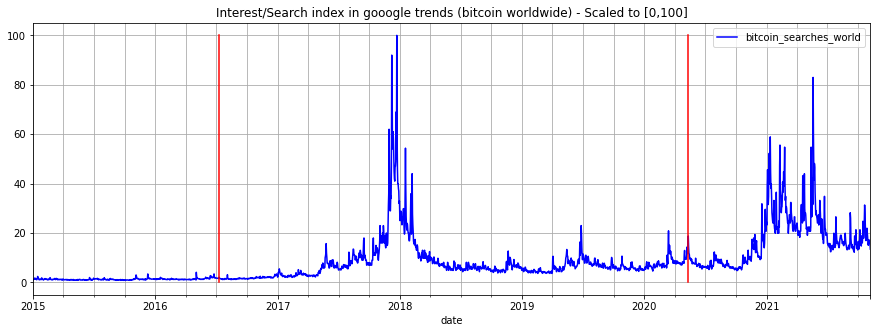

In [259]:
#%matplotlib ipympl
%matplotlib inline
#df_interest.plot(x='date',y='bitcoin_searches_world',figsize=(15,5),color='r')
df_interest.plot(y='bitcoin_searches_world',figsize=(15,5),color='b')
plt.plot([h2,h2],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.plot([h3,h3],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.title('Interest/Search index in gooogle trends (bitcoin worldwide) - Scaled to [0,100]')
ax = plt.gca()
ax.grid(which="both", color="darkgray", linestyle="-")
plt.show()

### BTC Price

In [260]:
df_price = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)

In [261]:
df_price['Date'] = pd.to_datetime(df_price['Date'])

In [262]:
df_price.set_index('Date',inplace=True)

In [263]:
df_price.tail()

,Open,High,Low,Close,Volume BTC
Date,,,,,
2021-11-09 20:00:00,66823.93,67396.71,66684.75,67358.43,50.882830
2021-11-09 21:00:00,67358.43,67811.30,67269.11,67736.19,49.606191
2021-11-09 22:00:00,67736.19,67746.50,67022.34,67315.89,25.229918
2021-11-09 23:00:00,67315.89,67446.22,66767.49,66948.11,19.554279
2021-11-10 00:00:00,66948.11,67129.33,66933.62,67112.56,4.767027


In [264]:
df_price.describe()

,Open,High,Low,Close,Volume BTC
count,51689.000000,51689.000000,51689.000000,51689.000000,53388.000000
mean,11660.286615,11728.639801,11586.714594,11661.597746,135.781857
std,15435.619691,15530.151618,15333.684495,15437.420499,266.463858
min,0.000000,243.600000,0.000000,243.600000,0.000000
25%,1192.250000,1195.770000,1188.840000,1192.330000,18.524166
50%,6913.940000,6949.990000,6875.000000,6914.080000,55.844551
75%,10685.520000,10736.110000,10629.990000,10685.630000,144.723689
max,68525.750000,68534.110000,68163.530000,68525.750000,8526.751048


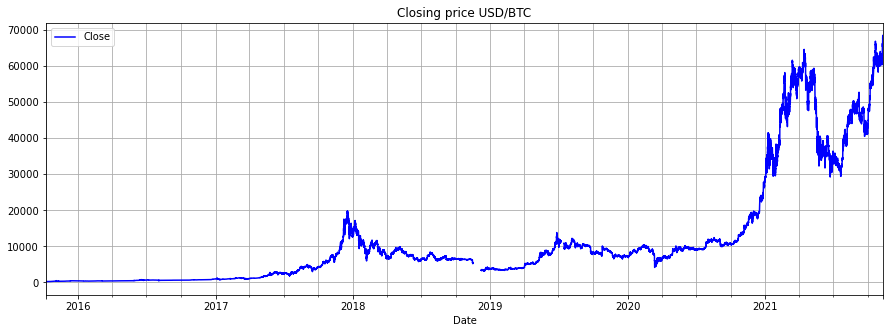

In [265]:
#%matplotlib ipympl
%matplotlib inline
df_price.plot(y='Close',figsize=(15,5),color='b')
# FIXME: (low prio) vertical lines are not plotted, maybe because they have no associated data index...?
ax = plt.gca()
ax.plot([h2,h2],[0,df_price['Close'].max()],color='r')
ax.plot([h3,h3],[0,df_price['Close'].max()],color='r')
ax.grid(which="both", color="darkgray", linestyle="-")
plt.title('Closing price USD/BTC')
plt.show()

## 2. Price level histograms
Halving epochs are analyzed starting from the halving date until the all-time-high (ATH) of the epoch.
The number of hours at each price level is computed and ploted.

**Note that the most interesting analysis in this section consists in ploting side by side the diagrams from different halving epochs.**
That was not done; instead, a workaround consists in un/commenting each halving period (start & end datatimes) and ploting everything sequentially:
first one halving, un/comment, then the other halving.

In [266]:
# Halving 2016: 2016-07-09
# ATH 2017: 2017-12-17
#start = dt.datetime(2016,7,9,0,0,0)
#end = dt.datetime(2017,12,17,0,0,0)
#end = dt.datetime(2017,9,15,0,0,0)
#start = h2
#end = a2
# Halving 2020: 2020-05-11
# ATH 2021: ?
#start = dt.datetime(2020,5,11,0,0,0)
start = h3
end = dt.datetime(2021,11,8,0,0,0)
if (df_price.index[-1] < end or df_interest.index[-1] < end):
    end = min([df_price.index[-1],df_interest.index[-1]])
duration_days = (end-start).days

In [267]:
duration_days

544

In [268]:
df_price.loc[start:end].shape

(13057, 5)

In [269]:
df_price.loc[start]

Open          8726.710000
High          8811.250000
Low           8709.620000
Close         8775.000000
Volume BTC      82.002092
Name: 2020-05-11 00:00:00, dtype: float64

In [270]:
# Slice data window and get max & min & ref price values
# n: number of bins or price levels for which the accumulated hours are summed
df_window = df_price.loc[start:end]
n = 100
max_price = df_window['Low'].max()
min_price = df_window['Low'].min()
ref_price = df_window['Low'].iloc[0]
print('min_price = {}, ref_price = {}, max_price = {}'.format(min_price, ref_price, max_price))
# Factor: price / ref price
df_price['Factor'] = df_price['Low']/ref_price
df_window = df_price.loc[start:end]
max_factor = df_window['Factor'].max()
min_factor = df_window['Factor'].min()
step_factor = (max_factor - min_factor) / (n-1)
step_price = (max_price - min_price) / (n-1)
print('min_factor = {}, max_factor = {}, step_factor = {}, step_price = {}'.format(min_factor, max_factor, step_factor, step_price))

min_price = 8200.0, ref_price = 8709.62, max_price = 66357.6
min_factor = 0.9414876883262415, max_factor = 7.6188857837655375, step_factor = 0.06744846561049794, step_price = 587.4505050505051


In [271]:
# Sum number of hours for each price level / bin
price_bins = np.zeros(n)
for i in range(df_window.shape[0]):
    if not (np.isnan(df_window.iloc[i]['Low'])):
        b = np.int(np.floor((df_window.iloc[i]['Low'] - min_price) / step_price))
        price_bins[b] = price_bins[b] + 1

In [272]:
# Hours in each price level or bin
price_bins

array([ 61., 949., 722., 355., 611., 758., 257.,  43., 180., 127.,  17.,
        49., 110.,  86.,  59.,  40., 129., 178., 258.,  28.,   1.,   7.,
         5.,   8.,  62.,  87.,  48.,  11.,  12.,   7.,  15.,  49.,  16.,
        14.,  19.,  47.,  40.,  24.,  61., 173., 162., 214., 173., 238.,
       211., 128., 189., 159., 159., 153., 136., 130., 130., 131.,  84.,
        52.,  66.,  62.,  80.,  99.,  76., 106., 122., 126., 168., 175.,
       228., 208., 202., 178., 140., 114.,  63.,  77.,  50.,  41.,  51.,
       107., 157., 154., 138., 154., 163., 177., 161., 138., 109.,  85.,
        89., 150., 108.,  88.,  94.,  53.,  25.,   9.,   5.,   6.,   6.,
         1.])

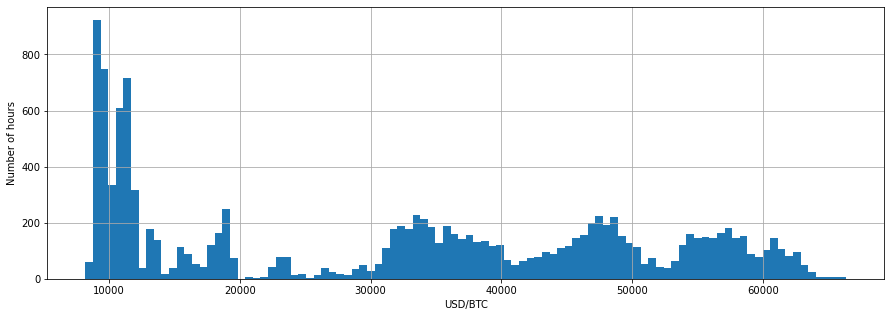

In [273]:
df_window['Low'].hist(bins=100,figsize=(15,5))
plt.xlabel('USD/BTC')
plt.ylabel('Number of hours')
ax = plt.gca()
ax.grid(which="both", color="darkgray", linestyle="-")

Text(0, 0.5, 'Number of hours')

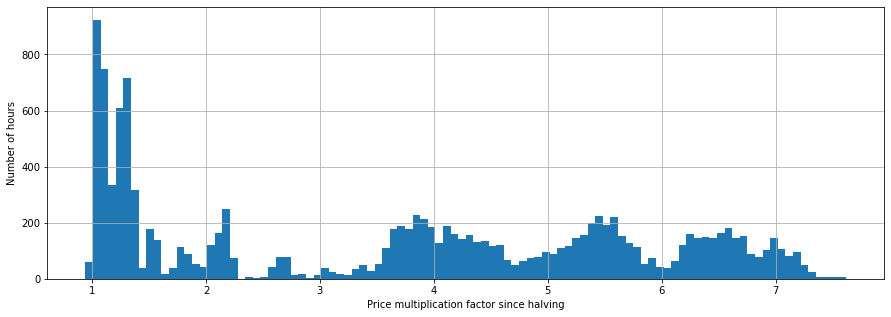

In [274]:
# Same plot as before, but with price increase factor wrt reference price
df_window['Factor'].hist(bins=100,figsize=(15,5))
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0, 0.5, 'Number of hours')

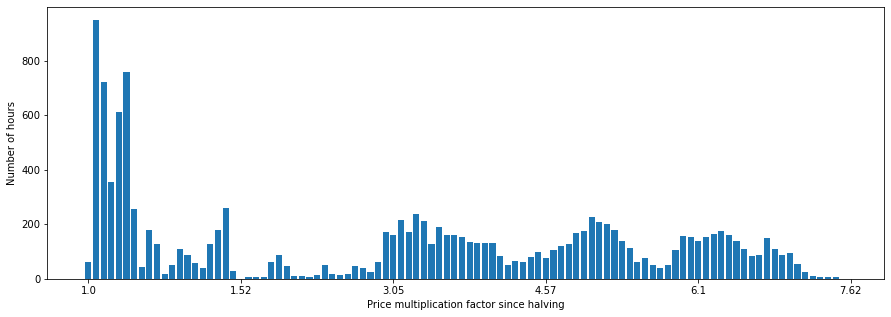

In [275]:
# Same plot as before, but done manually
# FIXME: However, note that the x tick values are different...
#%matplotlib ipympl
%matplotlib inline
plt.figure(figsize=(15,5))
#plt.bar(x=np.linspace(min_price,max_price,n),height=price_bins)
plt.bar(x=range(n),height=price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

In [276]:
# For each bin/price level, th enumber of hours in that level or higher are summed
# That is the integral, basically
acc_price_bins = np.zeros(n)
l = range(n)
for i in l[::-1]:
    acc_price_bins[i] = price_bins[i:-1].sum()

In [277]:
x = np.linspace(min_price,max_price,n)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0, 0.5, 'Number of hours in factor range or smaller')

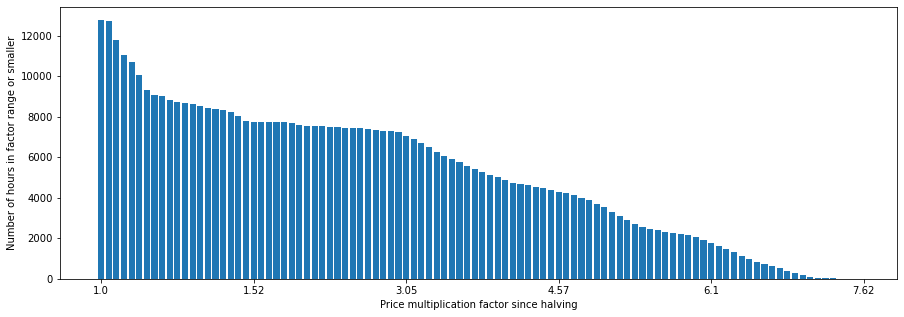

In [278]:
# Plot the integral of the price level values
plt.figure(figsize=(15,5))
plt.bar(x=range(n),height=acc_price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours in factor range or smaller')

In [279]:
acc_price_bins

array([1.2780e+04, 1.2719e+04, 1.1770e+04, 1.1048e+04, 1.0693e+04,
       1.0082e+04, 9.3240e+03, 9.0670e+03, 9.0240e+03, 8.8440e+03,
       8.7170e+03, 8.7000e+03, 8.6510e+03, 8.5410e+03, 8.4550e+03,
       8.3960e+03, 8.3560e+03, 8.2270e+03, 8.0490e+03, 7.7910e+03,
       7.7630e+03, 7.7620e+03, 7.7550e+03, 7.7500e+03, 7.7420e+03,
       7.6800e+03, 7.5930e+03, 7.5450e+03, 7.5340e+03, 7.5220e+03,
       7.5150e+03, 7.5000e+03, 7.4510e+03, 7.4350e+03, 7.4210e+03,
       7.4020e+03, 7.3550e+03, 7.3150e+03, 7.2910e+03, 7.2300e+03,
       7.0570e+03, 6.8950e+03, 6.6810e+03, 6.5080e+03, 6.2700e+03,
       6.0590e+03, 5.9310e+03, 5.7420e+03, 5.5830e+03, 5.4240e+03,
       5.2710e+03, 5.1350e+03, 5.0050e+03, 4.8750e+03, 4.7440e+03,
       4.6600e+03, 4.6080e+03, 4.5420e+03, 4.4800e+03, 4.4000e+03,
       4.3010e+03, 4.2250e+03, 4.1190e+03, 3.9970e+03, 3.8710e+03,
       3.7030e+03, 3.5280e+03, 3.3000e+03, 3.0920e+03, 2.8900e+03,
       2.7120e+03, 2.5720e+03, 2.4580e+03, 2.3950e+03, 2.3180e

In [280]:
# In the 20 highest price levels (linear split),
# how many hours did the price stay in that level or above?
acc_price_bins[80:-1]

array([1758., 1620., 1466., 1303., 1126.,  965.,  827.,  718.,  633.,
        544.,  394.,  286.,  198.,  104.,   51.,   26.,   17.,   12.,
          6.])

## 3. BTC Price-Interest Relationship

This section computes the scatterplot between the BTC price and the Google trend interest (number of searches scaled to 0-100).
Additionally, a linear regression is ccomputed (correlation, interecpt, slope).

In [281]:
# Arrange a custom dataframe
df_tmp = pd.DataFrame()
df_tmp['close'] = df_price['Close'].resample(rule='D').last().loc[start:end]
df_tmp['factor'] = df_price['Factor'].resample(rule='D').last().loc[start:end]
df_tmp['interest'] = df_interest['bitcoin_searches_world'].loc[start:end]
df_tmp['date'] = df_interest.loc[start:end].index
df_tmp['day'] = range((end-start).days+1)

The scatterplot reveals that different periods in time are clearly associated to different BTC-Interest relationships.
Therefore, a colormap like the one chosen helps better visualize that.
However, a better approach would be to perform a k-means clustering, and then, for each cluster the linear regression.

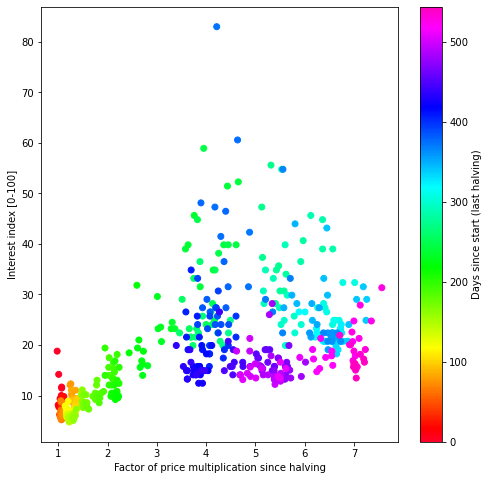

In [282]:
plt.figure(figsize=(8,8))
#df1.plot.scatter(x='A',y='B',c='C',cmap='coolwarm')
#https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#plt.scatter(x=df_tmp['factor'],y=df_tmp['interest'],c=df_tmp['day'],cmap='coolwarm')
plt.scatter(x=df_tmp['factor'],y=df_tmp['interest'],c=df_tmp['day'],cmap='gist_rainbow')
plt.xlabel('Factor of price multiplication since halving')
plt.ylabel('Interest index [0-100]')
cbar = plt.colorbar()
cbar.set_label('Days since start (last halving)')

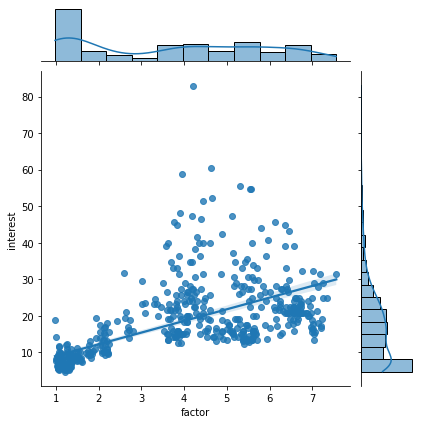

In [283]:
sns.jointplot(x='factor',y='interest',data=df_tmp,kind='reg')

In [284]:
from sklearn.linear_model import LinearRegression

In [285]:
# In general, I would say that there a weak or no linear relationship between both variables in the complete period
# There seems to be a higher correlation between the price and the time :)
# If clustering is applied, as noted above, better regression values are expected for each sub-period
df_tmp.corr()

,close,factor,interest,day
close,1.000000,0.999936,0.624476,0.844836
factor,0.999936,1.000000,0.620587,0.844835
interest,0.624476,0.620587,1.000000,0.440458
day,0.844836,0.844835,0.440458,1.000000


In [286]:
lm = LinearRegression()

In [287]:
X = df_tmp['factor'].values.reshape(df_tmp['factor'].shape[0],1)
X.shape

(545, 1)

In [288]:
y = df_tmp['interest'].values.reshape(df_tmp['interest'].shape[0],1)
y.shape

(545, 1)

In [289]:
lm.fit(X,y)

LinearRegression()

In [290]:
# Intercept: alpha: which is the base interest value if no price factor is present? (i.e., factor = 1)
lm.intercept_

array([5.85459686])

In [291]:
# Slope: beta: for an increase of a factor unit, how much does the interest increase?
# Caveat: Factors are not linear value increases, but percentual ratios related to the reference value...
lm.coef_

array([[3.18981396]])

In [292]:
predictions = lm.predict(X)

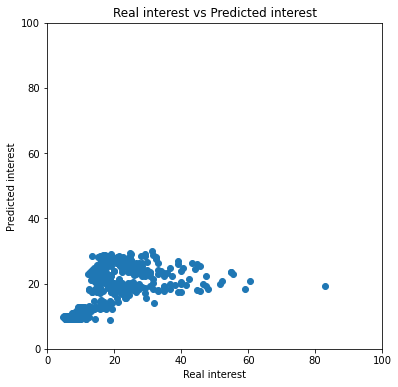

In [293]:
# Real interest against predicted interest
# We should get something close to the y=x line
plt.figure(figsize=(6,6))
plt.scatter(x=y,y=predictions)
plt.plot([0,0],[100,100],'-r')
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('Real interest vs Predicted interest')
plt.xlabel('Real interest')
plt.ylabel('Predicted interest')
plt.show()

## 4. Low and Upper Baselines

Here polynomials are fitted to upper and bottom values during the selected time period, specified in the previous section.
The Vandermonde matrix is built with day values (X) and linked to the price values through a linear equation (y).
The pseudoinverse of X premultiplied to y yields the coefficients of the polynomial.
The degree of the polynomial can be chosen manually -- the quadratic seems to work best.

In [294]:
# Low: dates chosen manually by visually inspecting the price curve
# 2020-07-20
# 2020-10-18
# 2020-11-27
# 2021-07-21
# 2021-10-01
low_dates = np.array([dt.datetime(2020,7,20,0,0,0),
             dt.datetime(2020,10,18,0,0,0),
             dt.datetime(2020,11,27,0,0,0),
             dt.datetime(2021,7,21,0,0,0),
             dt.datetime(2021,10,1,0,0,0)])
low_days = low_dates - h3
low_days = np.array([d.days for d in low_days])
# High: dates chosen manually by visually inspecting the price curve
# 2020-08-18
# 2020-11-30
# 2021-01-09
# 2021-02-22
# 2021-04-14
high_dates = np.array([dt.datetime(2020,8,18,0,0,0),
              dt.datetime(2020,11,30,0,0,0),
              dt.datetime(2021,1,9,0,0,0),
              dt.datetime(2021,2,22,0,0,0),
              dt.datetime(2021,4,14,0,0,0)])
high_days = high_dates - h3
high_days = np.array([d.days for d in high_days])

In [295]:
low_days

array([ 70, 160, 200, 436, 508])

In [296]:
high_days

array([ 99, 203, 243, 287, 338])

In [297]:
# DEGREE of polynomials
degree = 2

In [298]:
# Low polynomial: Support
x = low_days
X = np.vander(x, N=degree+1, increasing=True)
y = df_tmp['close'].loc[low_dates].values

In [299]:
X_pinv = np.linalg.pinv(X)
b_low = np.matmul(X_pinv,y)

In [300]:
# b: b0, b1, b2, ... -> b0 + b1*x + b2*x**2 + ...
b_low

array([ 1.00859744e+04, -1.20644498e+01,  1.62518822e-01])

In [301]:
# High polynomial: Resistance
x = high_days
X = np.vander(x, N=degree+1, increasing=True)
y = df_tmp['close'].loc[high_dates].values
X_pinv = np.linalg.pinv(X)
b_high = np.matmul(X_pinv,y)

In [302]:
# b: b0, b1, b2, ... -> b0 + b1*x + b2*x**2 + ...
b_high

array([ 5.95125494e+03, -9.00979296e+00,  5.53863193e-01])

Once all polynomial coefficients are known, we simply plot the price and the support curves.
We need to compute the polynomial values for that.

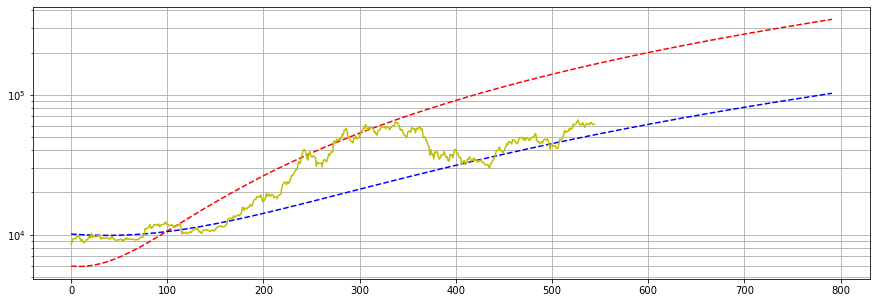

In [303]:
# FIXME: display dates in X axis rather than day numbers...
today = dt.datetime(2021,11,4,0,0,0)
#offset = 0
offset = 250
x = np.arange((today-h3).days+offset)
y_low = np.zeros(len(x))
y_high = np.zeros(len(x))
for i in range(len(b_low)):
    b = b_low[i]
    y_low = y_low + b*(x**i)
for i in range(len(b_high)):
    b = b_high[i]
    y_high = y_high + b*(x**i)
plt.figure(figsize=(15,5))
plt.plot(x,y_high,'r--')
plt.plot(x,y_low,'b--')
#
y_close = df_tmp['close'].values
min_d = min(len(x),len(y_close))
plt.plot(x[:min_d],y_close[:min_d],'y')
ax=plt.gca()
ax.set_yscale('log')
ax.grid(which="both", color="darkgray", linestyle="-")

## 5. Comparisons: BTC, ETH, SPY

In this section different price values are compared along the selected time period: BTC, ETH, SPY.
SPY is the ETF that contains the whole SP500, so it represents the SP500 market.

In [304]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
%matplotlib inline
#%matplotlib notebook

In [305]:
# Halving 2016: 2016-07-09
# ATH 2017: 2017-12-17
#start = dt.datetime(2016,7,9,0,0,0)
#end = dt.datetime(2017,12,17,0,0,0)
#end = dt.datetime(2017,9,15,0,0,0)
# Halving 2020: 2020-05-11
# ATH 2021: ?
#start = dt.datetime(2020,5,11,0,0,0)
start = h3
end = dt.datetime(2021,11,8,0,0,0)

In [306]:
df_btc = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc.set_index('Date',inplace=True)

In [307]:
df_btc.head()

,Open,High,Low,Close,Volume BTC
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [308]:
df_eth = pd.read_csv('data/Bitstamp_ETHUSD_2017_2021_hourly.csv',header=0)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_eth.set_index('Date',inplace=True)

In [309]:
df_eth.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2017-08-16 16:00:00,300.0,300.0,300.0,300.0,0.02,6.0
2017-08-16 17:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 18:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 19:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 20:00:00,300.0,300.0,300.0,300.0,0.00,0.0


In [310]:
# Get SPY data with the pandas data-reader
df_spy = data.DataReader("SPY", 'yahoo', start, end)

In [311]:
df_spy.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-11,294.000000,289.880005,290.339996,292.500000,79514200.0,286.028168
2020-05-12,294.239990,286.519989,293.790009,286.670013,95870800.0,280.327209
2020-05-13,287.190002,278.959991,286.059998,281.600006,144721100.0,275.369385
2020-05-14,285.109985,272.989990,278.950012,284.970001,121977900.0,278.664795
2020-05-15,286.329987,281.339996,282.369995,286.279999,111146300.0,279.945862


In [312]:
df_btc['btc'] = df_btc['Close']
df_eth['eth'] = df_eth['Close']
df = pd.concat([df_btc['btc'], df_eth['eth']], axis = 1,join='outer').dropna()

In [313]:
df = df.resample(rule='D').last().loc[start:end]

In [314]:
df_spy['spy'] = df_spy['Adj Close']
df = pd.concat([df, df_spy['spy']], axis = 1,join='outer').dropna()

<AxesSubplot:xlabel='Date'>

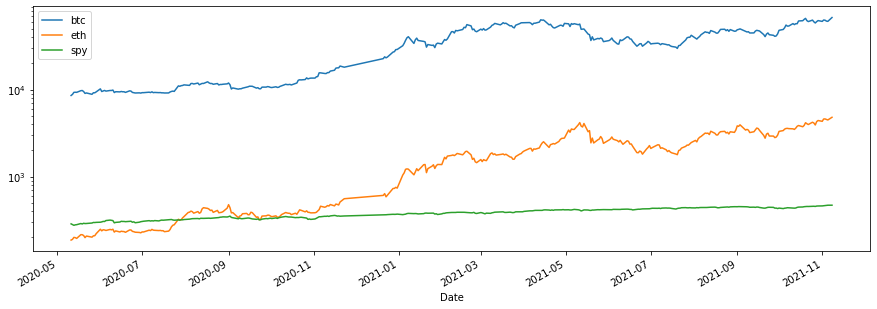

In [315]:
df.plot(figsize=(15,5),logy=True)

In [316]:
df.head()

,btc,eth,spy
Date,,,
2020-05-11,8571.50,186.18,286.028168
2020-05-12,8822.66,189.79,280.327209
2020-05-13,9311.58,199.80,275.369385
2020-05-14,9338.85,198.58,278.664795
2020-05-15,9314.16,194.57,279.945862


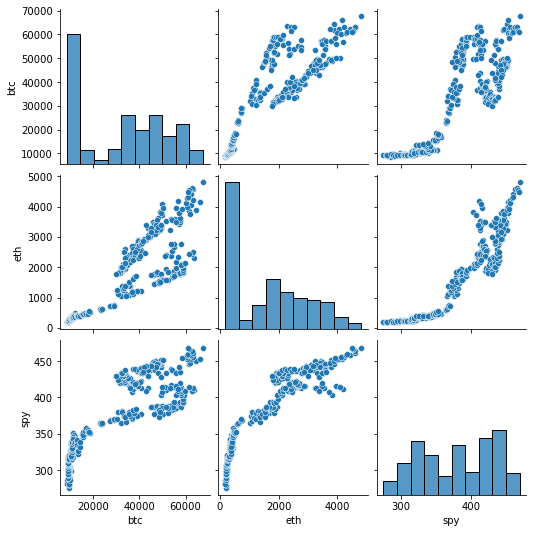

In [317]:
sns.pairplot(df)

### Scatterplot: ETH vs BTC

Data from Halving 3 (2020-) suggests that we could cluster different periods of time to perform regressions of each subspace.
In general, it seems that when a new period starts, the correlation is quite high and then it decreses.
Plotting the scatterplot with the colormap helps to better understand that concept.

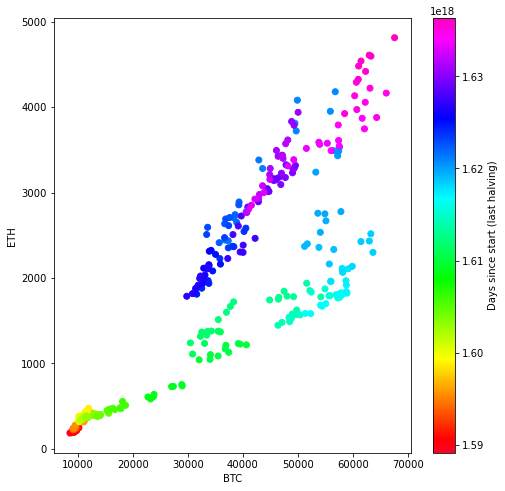

In [318]:
plt.figure(figsize=(8,8))
#https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
plt.scatter(x=df['btc'],y=df['eth'],c=df.index,cmap='gist_rainbow')
plt.xlabel('BTC')
plt.ylabel('ETH')
cbar = plt.colorbar()
cbar.set_label('Days since start (last halving)')

### Returns

Now, the returns (daily percent changes) are analyzed for each of the three assets: BTC, ETH, SPY.

In [319]:
returns = pd.DataFrame()
for asset in df.columns:
    returns[asset] = df[asset].pct_change()
# The return percent of the first day is NaN
returns.head()

,btc,eth,spy
Date,,,
2020-05-11,NaN,NaN,NaN
2020-05-12,0.029302,0.019390,-0.019931
2020-05-13,0.055416,0.052743,-0.017686
2020-05-14,0.002929,-0.006106,0.011967
2020-05-15,-0.002644,-0.020193,0.004597


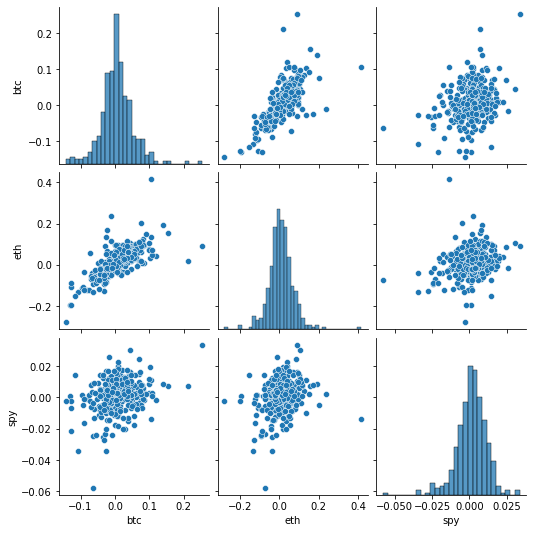

In [320]:
sns.pairplot(returns[1:].dropna())

<AxesSubplot:xlabel='eth', ylabel='Count'>

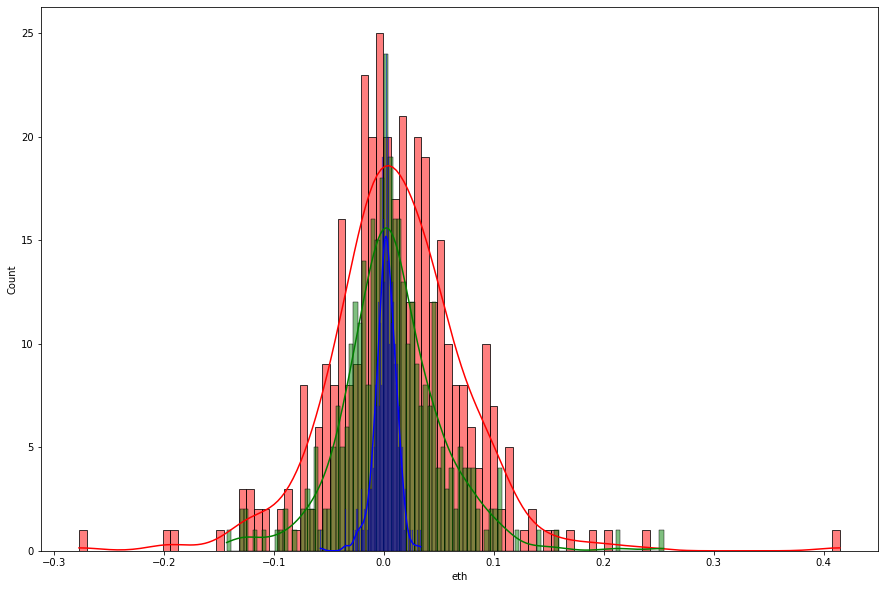

In [321]:
# The wider the distribution, the higher the variance
# We see visually that var(ETH) > var(BTC) > var(SPY)
# Higher variance, higher risk, but also higher return...
plt.figure(figsize=(15,10))
sns.histplot(returns['eth'],
             color='red',
             bins=100,
             kde=True)
sns.histplot(returns['btc'],
             color='green',
             bins=100,
             kde=True)
sns.histplot(returns['spy'],
             color='blue',
             bins=100,
             kde=True)

#### Correlation matrices

Correlation matrix encoded with colors: very intuitive for visual people (most of us).
Three types of results are analyzed, leading to interesting observations:
- All returns (positive and negative): ETH and BTC seem quite correlated, but SPY is decoupled from both of them
- Positive returns: There seems to be no relevant correlation between any of them
- Negative returns: These a stong correlation between ETH and BTC, but not for SPY

Therefore, insights:
- BTC & ETH are decoupled from SP500 stocks
- When BTC or ETH increase, the counterpart does not have to increase necessarily
- When BTC or ETH decrease, the couterpart does too

<AxesSubplot:>

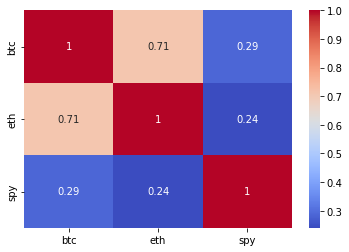

In [322]:
# All returns
sns.heatmap(returns.corr(), cmap='coolwarm', annot=True)

<AxesSubplot:>

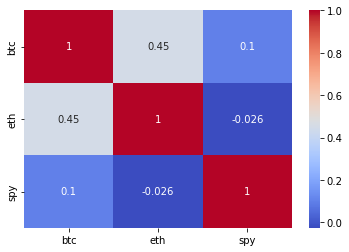

In [323]:
# Only positive returns
sns.heatmap(returns[returns>0].corr(), cmap='coolwarm', annot=True)

<AxesSubplot:>

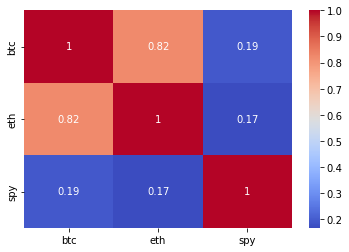

In [324]:
# Only mnegative returns
sns.heatmap(returns[returns<0].corr(), cmap='coolwarm', annot=True)

<AxesSubplot:xlabel='Date'>

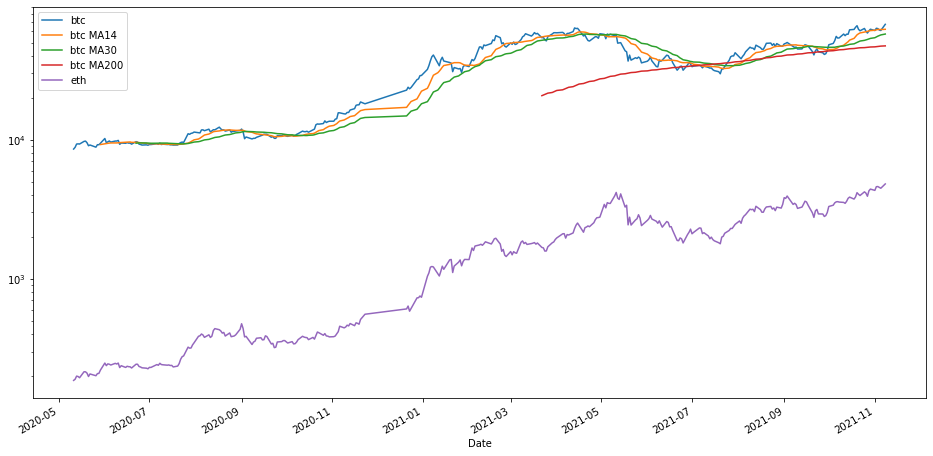

In [325]:
# Significant averaging periods:
# 14: because of the difficulty adjustement
# 30: one month
# 200 days: typically, tehre seems to be a bottom there
df['btc MA14'] = df['btc'].rolling(14).mean()
df['btc MA30'] = df['btc'].rolling(30).mean()
df['btc MA200'] = df['btc'].rolling(200).mean()
df[['btc','btc MA14','btc MA30','btc MA200','eth']].plot(figsize=(16,8),logy=True)

### Plotly

In this section, some nice plotting is done thanks to Plotly.

In [326]:
import plotly
import chart_studio.plotly as py
import cufflinks as cf

In [327]:
# Import plotly-offline modules
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Connect Javascript to our notebook - this is for notebook development
init_notebook_mode(connected=True)
# In order to work offline through cufflinks, we need to run this:
cf.go_offline()

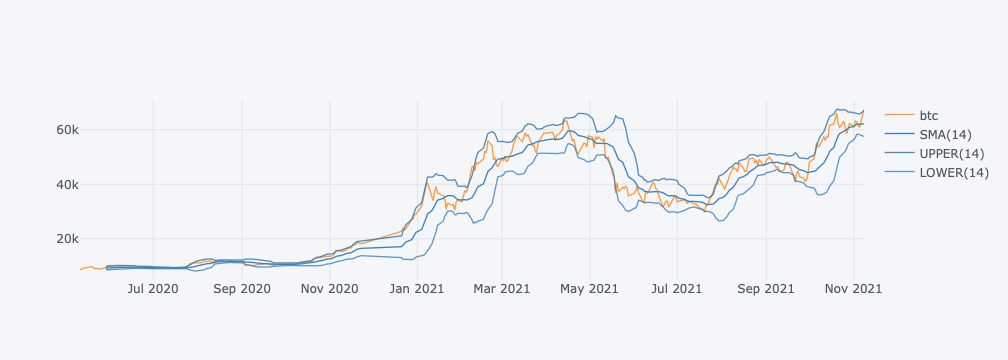

In [328]:
df['btc'].ta_plot(study='boll')